# Importing libraries and loading data

In [1]:
import tensorflow as tf
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import initializers
from utils import *

# Process weathertypes, remove empty windspeed and store (ignore if already done)

In [2]:
combined_path = "./data/combined_data.tsv"
weather_combined_path="./data/combined_one_hot_data.tsv"

if not check_if_the_tsv_hot_file_already_has_processed_columns(weather_combined_path):
    df = pd.read_csv(combined_path,
                     sep='\t',
                     header=0) 
    weather_unique_combinations = df.weather_condition.unique()

    #Get list of all unique weather types
    types = []
    for el in weather_unique_combinations:
        for wc in el.split('.'):
            if(wc != ''):            
                types.append(wc.strip())
    true_unique =  set(types)

    #Add columns with default value 0 for all unique weather types
    for unique_weather_type in true_unique:
        df[unique_weather_type]=0

    #Loop over all records and set value to 1 for their corresponding weather_types
    for index, row in df.iterrows():
        row_types = []
        for wc in row["weather_condition"].split('.'):
            if(wc != ''):            
                row_types.append(wc.strip())
        for t in row_types:
            df.at[index,t]=1


    #remove empty windspeeds
    df = df[df.wind_speed.apply(lambda x: x.isnumeric())]

    #remove original weather_condition column and store, to avoid rerun
    df =  df.drop(columns="weather_condition")
    df.to_csv(weather_combined_path,
              sep='\t',
              index=False,
              header=True)    
else:
    print("File already processed.")

File already processed.


# Load in data with one_hot weather types

In [2]:
weather_combined_path="./data/combined_one_hot_data.tsv"
df = pd.read_csv(weather_combined_path,
                 sep='\t',
                 header=0)

#choose one station to test on
#df=df[df['device_name']=='CB1143']
print(df)

      device_name  latitude  longitude  timestamp_from  timestamp_until  \
0          CEK049  50.82448   4.393893      1544095800       1544096700   
1          CEK049  50.82448   4.393893      1544096700       1544097600   
2          CEK049  50.82448   4.393893      1544097600       1544098500   
3          CEK049  50.82448   4.393893      1544098500       1544099400   
4          CEK049  50.82448   4.393893      1544099400       1544100300   
5          CEK049  50.82448   4.393893      1544445900       1544446800   
6          CEK049  50.82448   4.393893      1544446800       1544447700   
7          CEK049  50.82448   4.393893      1544447700       1544448600   
8          CEK049  50.82448   4.393893      1544448600       1544449500   
9          CEK049  50.82448   4.393893      1544449500       1544450400   
10         CEK049  50.82448   4.393893      1544510700       1544511600   
11         CEK049  50.82448   4.393893      1544511600       1544512500   
12         CEK049  50.824

# Remove outliers (bike_count)

In [3]:
def remove_outlier(df_in, col_name):
    """Removes all outliers on a specific column from a given dataframe.

    Args:
        df_in (pandas.DataFrame): Iput pandas dataframe containing outliers
        col_name (str): Column name on which to search outliers

    Returns:
        pandas.DataFrame: DataFrame without outliers
    """         
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1  # Interquartile range
    fence_low = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)] 

df = remove_outlier(df, "bike_count")


# Correlation of variables


In [ ]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(18,18))    

correlation_matrix = df.corr().round(2)
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".001f",ax=ax)

# Feature selection

In [4]:
df = df.drop(columns=[
    'device_name',
    'timestamp_until',
    'bike_avg_speed',
    'weather_timestamp',
    'wind_direction',
    'wind_speed',
    'barometer',
    'visibility',
    'Ice fog',
    'Thundershowers',
    'Sprinkles',
    'Broken clouds',
    'Rain showers',
    'Snow flurries',
    'Light fog',
    'Sleet',
    'Cloudy',
    'Quite cool'    
])
print(df.shape)

(80856, 28)


# Build models

In [14]:
def build_normal_model():
    
    initializer = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
    model = Sequential()   
    
    model.add(Dense(26, input_dim=26,kernel_initializer='normal', activation='relu'))
    model.add(Dense(26,activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])
    model.summary()
    return model
normal_model = build_normal_model()

def build_lstm_model():
    
    model = Sequential()       
    model.add(LSTM(26, input_shape=(1,26),kernel_initializer='normal', return_sequences=True))
    model.add(LSTM(26, return_sequences=True))
    model.add(LSTM(26, activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])
    model.summary()
    return model

model = normal_model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 26)                702       
_________________________________________________________________
dense_17 (Dense)             (None, 26)                702       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 27        
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________


# Set timestamp as index, set x & y

In [6]:

df.set_index('timestamp_from', inplace=True)
df = df.sort_values(by=['timestamp_from'])

#set bike_count as Y
df_y = df.bike_count
df_x = df.drop(columns="bike_count")

In [7]:



#Normalization
x = df_x.values
y = df_y.values.reshape(-1, 1)

x_scaler = preprocessing.MinMaxScaler()
x_normalized = x_scaler.fit_transform(x)

y_scaler = preprocessing.MinMaxScaler()
y_normalized = y_scaler.fit_transform(y)

x_in = pd.DataFrame(x_normalized)
y_in = pd.DataFrame(y_normalized)


#Prepare train & test dataset
test_size = 0.2
total = x_in.shape[0]
train_idx = round((1-test_size) * total)



x_train = x_in[0:train_idx].values
#x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

x_test = x_in[train_idx+1:total-1].values
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

y_train = y_in[0:train_idx].values
y_test = y_in[train_idx+1:total-1]



print("x_train shape {}".format(x_train.shape))
print("y_train shape {}".format(y_train.shape))

x_train shape (64685, 26)
y_train shape (64685, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Train models

In [ ]:
model.fit(x_train, y_train, epochs=8)

Epoch 1/8
64685/64685 [==============================] - 7s 116us/sample - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1621
Epoch 2/8
64685/64685 [==============================] - 7s 115us/sample - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1539
Epoch 3/8
64685/64685 [==============================] - 7s 116us/sample - loss: 0.0404 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1501
Epoch 4/8
64685/64685 [==============================] - 8s 116us/sample - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1493


# Evaluate

16169/16169 [==============================] - 1s 56us/sample - loss: 0.0481 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1695
[[0.24356078]
 [0.30170244]
 [0.38066798]
 ...
 [0.17711383]
 [0.08577235]
 [0.10645164]]
37.72634158635222


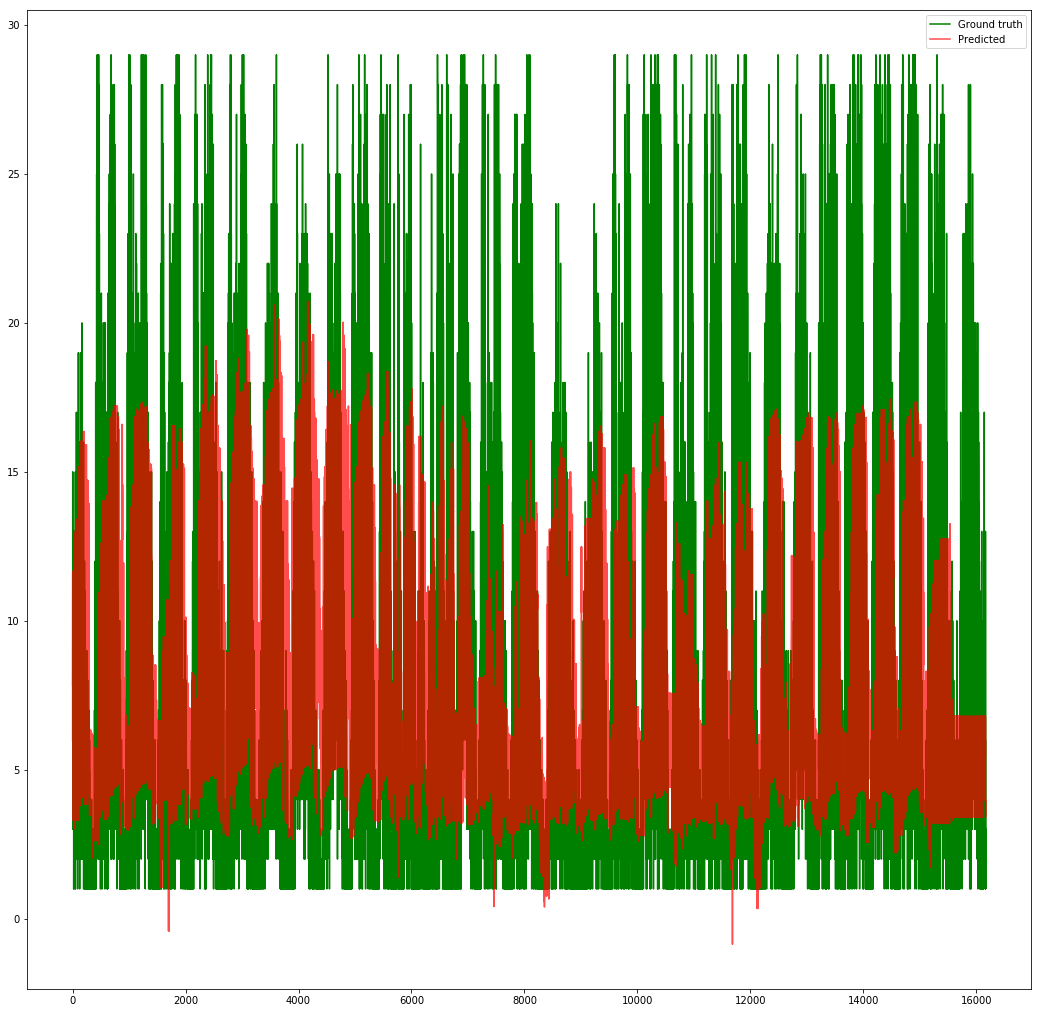

In [13]:
model.evaluate(x_test, y_test)

#x_test = x_train
#y_test = y_train

#x_test = x_test[14500:]
#print(x_test)
#y_test = y_test[14500:]


y_prediction = model.predict(x_test)
print(y_prediction)

y_pred_scaled = y_scaler.inverse_transform(y_prediction)



y_test_scaled = y_scaler.inverse_transform(y_test)
mse = mean_squared_error(y_pred_scaled, y_test_scaled)
print(mse)

plt.rcParams['figure.figsize'] = [18, 18]
l1, = plt.plot(y_test_scaled, 'g')
l2, = plt.plot(y_pred_scaled, 'r', alpha=0.7)
plt.legend(['Ground truth', 'Predicted'])
plt.show()
